# A Discrete Inquiry Into MCMC
This notebook illutrates Markov Chain Monte Carlo
on a finite state space. We are given a positive function $q$
on the the set $S = \{ 0, 1, ..., d-1 \}$ and seek a Markov chain $P' = P_{mcmc}$ on $S$ whose stationary 
distribution is $q\_dist = q/q.sum()$.

The code below chooses $q$ from a small menu using StationarySelector. We find $P_{mcmc}$ by first constructing a Markov chain $P$ on $S$ and then modifying $P$ into a suitable $P_{mcmc}$. The class BaseMarkovChainSelector contains a menu from which one chooses the first row of $P$, which specifies the transition probabilities from state 0 to other states. The method make_P_matrix then fills out the matrix $P$ by shifting the first row to create the other rows.

With $q\_dist$ and $P$ in hand, the function P_mcmc applies the MCMC algorithm to create $P_{mcmc}$.

In [1]:
import numpy as np
from scipy.stats import binom, norm
from math import isclose
import matplotlib.pyplot as plt

In [2]:
class StationarySelector:
    def __init__(self, dim):
        self.dim = dim
        
    def geometric(self, base):
        return base**np.arange(self.dim)

    def binomial(self, p: float):
        return binom.pmf(range(self.dim + 1), self.dim, p)

    def mix_binom(self, binom_probs: np.ndarray, mix_weights: np.ndarray) -> np.ndarray:
        """ mix_weights[:, None].shape = (len(mix_weights, 1) = (len(binom_probs), 1)
            binom_probs[:, None].shape = (len(binom_probs), 1)
            self.binomial(binom_probs[:, None]).shape = (len(binom_probs), self.dim)
            sum acts over axis 0
        """
        assert len(binom_probs) == len(mix_weights), 'the two parameter arrays have different lengths'
        assert isclose(mix_weights.sum(), 1.0), 'probabilities do not add to 1'

        return binom_probs * self.dim, np.sum(mix_weights[:, None] * self.binomial(binom_probs[:, None]), axis=0 )
            
    def normal(self, mean: float, std:float):
        return norm.pdf(range(self.dim + 1), loc=mean, scale=std)
        
    def mix_normal(self, means: np.ndarray, std_devs: np.ndarray, mix_weights: np.ndarray) -> np.ndarray:
        """ means are given as a fraction of self.dim """
        assert len(means) == len(std_devs) and len(std_devs) ==len(mix_weights), 'the  parameter arrays have different lengths'
        assert isclose(mix_weights.sum(), 1.0), 'probabilities do not add to 1'

        return means * self.dim, \
            sum(mix_weights[:, None] * self.normal(means[:, None] * self.dim, std_devs[:, None]))


### Choose a target distribution $q\_dist$ by choosing StationarySelector's method. 

#### Mixture of normals

[10. 40. 80.]


<BarContainer object of 101 artists>

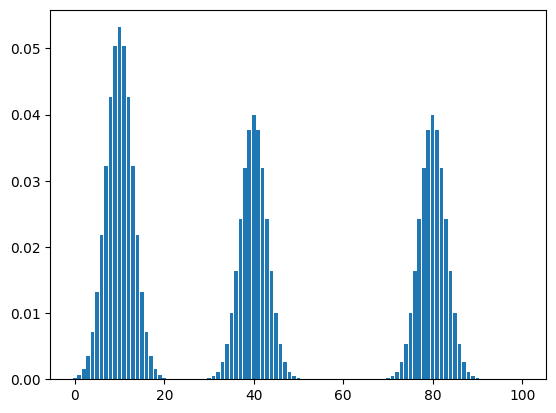

In [3]:
n_states = 101
n = StationarySelector(n_states - 1)

centers, q_dist = n.mix_normal(means=np.array([0.1, 0.4, 0.8]), 
                      std_devs = np.array([3, 3, 3]), 
                      mix_weights = np.array([0.4, 0.3, 0.3]))
print(centers)
plt.bar(range(len(q_dist)), q_dist)
                 

#### Mixture of binomials

(201,)
[ 40. 100. 160.]


<BarContainer object of 201 artists>

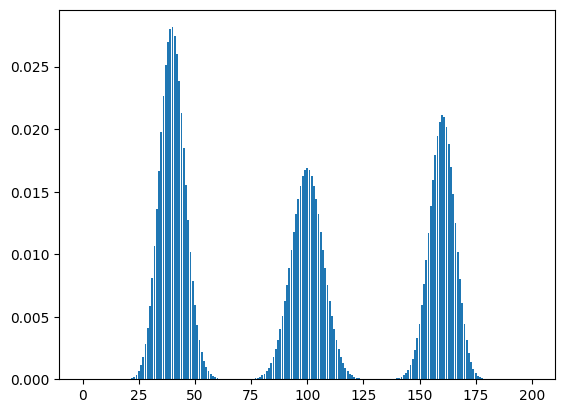

In [89]:
n_states = 201
selector = StationarySelector(n_states - 1)
centers, q_dist = selector.mix_binom(binom_probs=np.array([0.2, 0.5, 0.8]), 
                            mix_weights=np.array([0.4, 0.3, 0.3])
                           )
print(q_dist.shape)
print(centers)
plt.bar(range(len(q_dist)), q_dist)

#### Geometric

Stationary distribution q: 
 [0.1   0.09  0.081 0.073 0.066 0.059 0.053 0.048 0.043 0.039 0.035 0.032
 0.028 0.026 0.023 0.021 0.019 0.017 0.015 0.014 0.012 0.011 0.01  0.009
 0.008 0.007 0.006 0.006 0.005 0.005 0.004 0.004 0.003 0.003 0.003 0.003
 0.002 0.002 0.002 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001]
51


<BarContainer object of 51 artists>

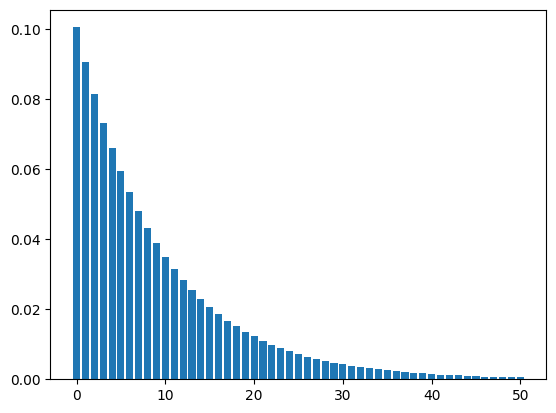

In [57]:
n_states = 51
selector = StationarySelector(n_states)
q = selector.geometric(base= 0.9)
q_dist = q/np.sum(q)  # normalize q for investigating convergence
print('Stationary distribution q: \n',np.round(q_dist,3))
print(len(q_dist))

plt.bar(range(len(q_dist)), q_dist)

In [5]:
# https://jaxenter.com/implement-switch-case-statement-python-138315.html
class BaseMarkovChainSelector:
    def __init__(self, dim, right):
        self.dim = dim
        self.right_jump = right
        
    def make_P_matrix(self, method: str):
        row = self.first_row(method)
        m = row
        for r in range(1,row.shape[1]):
            m = np.concatenate((m,
                                np.roll(row, r)),
                                axis=0)
        return m
        
    def first_row(self, method):
        """Dispatch method: method can be any of the functions below, such as clock_tick, uniform, uniform_jump, random_walk """
        method_name = str(method)
        # Get the method from 'self'. Default to a lambda.
        method = getattr(self, method_name, lambda: "Invalid distribution")
        # Call the method as we return it
        return method()
    
#   Markov chain with independent trials, uniform
    def uniform(self):
        return np.full((1, self.dim), 1.0/self.dim)
    
#   Jump from state 0 to other states with equal probability
    def uniform_jump(self):
        row = np.full((1,self.dim),1.0/(self.dim-1))
        row[0,0] = 0
        return row
    
#   Adjacent neighbor random walk on the circle
    def random_walk(self):
        row = np.zeros((1, self.dim))
        row[0, 1] = self.right_jump
        row[0, -1] = 1 - self.right_jump
        return row


### Choose the base Markov chain by choosing the argument of P_selector.make_P_matrix.

In [6]:
s  = BaseMarkovChainSelector(len(q_dist), 0.2)
P = s.make_P_matrix('random_walk')
P = s.make_P_matrix('uniform')
# P = s.make_P_matrix('uniform_jump')
print('P:\n', np.round(P,2))
print (P.shape)

P:
 [[0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 ...
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]
(101, 101)


The formula for the MCMC transition matrix $P_{mcmc} = P'$ is
\begin{equation*}
p'_{xy} = p_{xy} \min (1,{q_y p_{yx}}/{q_x p_{xy}} ) = \frac {\min (q_x p_{xy},q_y p_{yx})}{q_x}   \text{  if  } x \ne y
\end{equation*}

### Compute and display $P_{mcmc}$. 


In [7]:
def P_mcmc(P, q):
    A = np.diag(q) @ P
    C = np.minimum(A, A.T)  # the numerator of P'
    D = np.diag(1./q) @ C
    return  D + np.diag(1.0 - np.sum(D, axis=1))  # add probability to the diagonal term to make the rows sum to 1.
    
P_mcmc = P_mcmc(P, q_dist)
print('P_mcmc:\n',np.round(P_mcmc,2))

P_mcmc:
 [[0.38 0.01 0.01 ... 0.   0.   0.  ]
 [0.   0.43 0.01 ... 0.   0.   0.  ]
 [0.   0.   0.49 ... 0.   0.   0.  ]
 ...
 [0.01 0.01 0.01 ... 0.06 0.   0.  ]
 [0.01 0.01 0.01 ... 0.01 0.03 0.  ]
 [0.01 0.01 0.01 ... 0.01 0.01 0.01]]


A plot of the diagonal terms of P_mcmc shows that the terms near the peaks of q_dist are high: such states have high probability of repeated visits.

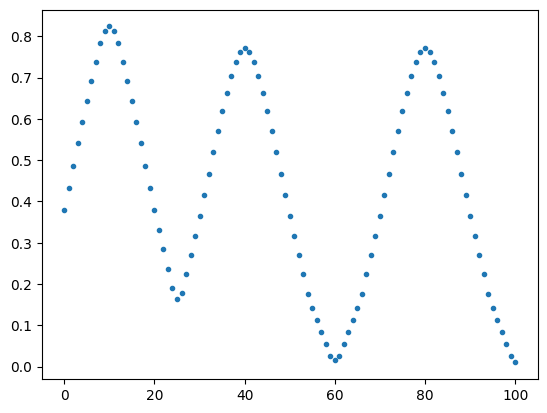

In [8]:
plt.scatter(range(len(P_mcmc)), np.diag(P_mcmc), s=9)

## Properties of $P_{mcmc}
The next few cells verify that the MCMC algorithm behaves as predicted and explore some of the algorithm's properties.

First, we verify that $q_{dist}$ is the stationary distribution by showing that $q_{dist} P_{mcmc} - q_{dist} = 0$.

In [61]:
diff = q_dist @ P_mcmc - q_dist
print('||qP_mcmc - q|| = ', np.sqrt(np.dot(diff, diff)))

||qP_mcmc - q|| =  8.573317967155792e-17


### How quickly does MCMC converge?

A standard result from Markov chains is that each row of the matrix power $(P')^n$ should converge to the stationary distribution $q$. The cell below finds the difference between the stationary distribution and each row of  $(P')^n$. Row $x$ is the distribution of the chain after $n$ steps, starting in state $x$.

The cell then calculates the largest difference, which represents the largest error over all initial states.  It uses two notions of difference, the total variation distance between a row of $(P')^n$ and $q$ and the Kullback-Leibler divergence. The square root of the KL divergence is known to bound the total variation distance.


P_mcmc ** 80 
 [[0.    0.001 0.002 ... 0.    0.    0.   ]
 [0.    0.001 0.002 ... 0.    0.    0.   ]
 [0.    0.001 0.002 ... 0.    0.    0.   ]
 ...
 [0.    0.001 0.002 ... 0.    0.    0.   ]
 [0.    0.001 0.002 ... 0.    0.    0.   ]
 [0.    0.001 0.002 ... 0.    0.    0.   ]]


Text(0.5, 1.0, 'Total variation and Kullback-Leibler distances of P**i from q')

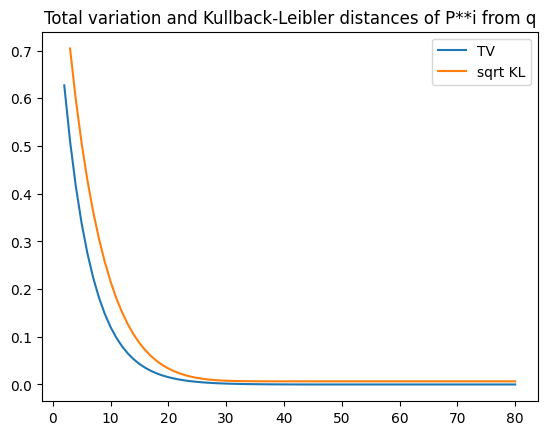

In [9]:
def convergence_rate(P: np.ndarray, max_power: int, stat_dist: np.ndarray):
    M = P
    tv_array = np.array([])
    kl_array = np.array([])
    for p in range(1, max_power):
        M = M @ P
        tv = 0.5 * np.max(np.sum(np.fabs(M - stat_dist), axis=1))
        kl = 0.5 * np.max(np.sum(M * np.nan_to_num(np.log(M/stat_dist)), axis=1))        
        tv_array = np.append(tv_array, tv)
        kl_array = np.append(kl_array, np.nan_to_num(kl))
       
#         print(p+1,'\t', np.round(tv,5),'\t', np.round(np.sqrt(kl),5))
    print('\nP_mcmc **', max_power, '\n',np.round(M,3))
    return(tv_array, np.sqrt(kl_array))

# print('Power\t', 'Tot var\t','sqrt KL')
iterations = 80
TV, KL = convergence_rate(P_mcmc, iterations, q_dist)
#print (TV, KL)

plt.figure()
plt.plot(np.arange(2, 2+TV.shape[0]), TV, label='TV')
plt.plot(np.arange(3, 2+TV.shape[0]), KL[1:],label="sqrt KL")
plt.legend(loc='best')
plt.title("Total variation and Kullback-Leibler distances of P**i from q")


### Eigenvalues of P_mcmc

Another well-known result about Markov chains (see https://en.wikipedia.org/wiki/Markov_chain#Steady-state_analysis_and_limiting_distributions ) is that the second largest eigenvalue of P_mcmc governs how quickly $(P')^n$ converges to a matrix all of whose rows are $q$.  The next cell calculates the rate.

In [20]:
#eigenvalues and eigenvectors of P_mcmc
from numpy import linalg as LA
e_values,e_vectors = LA.eig(P_mcmc.T)  # transpose to get left eigenvectors
print ('Eigenvalues of P_mcmc: ', np.round(e_values,2))

print('Geometric convergence rate (ratio of 2nd largest to largest eigenvalue) =', 
     np.round(np.sort(e_values)[-2]/np.sort(e_values)[-1],2))

Eigenvalues of P_mcmc:  [ 1.    0.81 -0.    0.01  0.01  0.8   0.8   0.77  0.77  0.01  0.76  0.76
  0.04  0.04  0.04  0.07  0.07  0.07  0.68  0.68  0.73  0.73  0.63  0.63
  0.58  0.58  0.53  0.53  0.47  0.47  0.42  0.42  0.36  0.36  0.14  0.09
  0.09  0.09  0.17  0.16  0.22  0.12  0.12  0.12  0.32  0.27  0.21  0.75
  0.75  0.75  0.75  0.69  0.69  0.72  0.72  0.72  0.72  0.69  0.69  0.65
  0.65  0.65  0.65  0.6   0.6   0.6   0.6   0.56  0.56  0.56  0.56  0.5
  0.5   0.5   0.5   0.45  0.45  0.45  0.45  0.4   0.4   0.4   0.4   0.16
  0.16  0.16  0.21  0.21  0.21  0.25  0.25  0.25  0.25  0.3   0.3   0.3
  0.3   0.35  0.35  0.35  0.35]
Geometric convergence rate (ratio of 2nd largest to largest eigenvalue) = 0.81


### Sample paths of P_mcmc

MCMC generates samples from the distribution $q$ by running the Markov chain P_mcmc and reading off the sequence of states the chain passes through (aka the sample path). The parameter "path_len" below is the length of the sample path. 

To build a sample path we choose states successively. If the chain is in state x, the next state occurs with probability 
given by the discrete distribution in the row vector
$P_{mcmc}[x]$. To sample from a discrete distribution, such as $[\pi [0], ..., \pi [n]]$ we generate $u$ from a Uniform[0, 1] distribution.
The next sample is $j$ if $\pi[0] + ... + \pi[j-1] \leq u$ and $\pi[0] + ... + \pi[j] > u$.

The partial sums that we compare to $u$ are in the cumsum matrix $C$.

0 91
(101,) (101,)


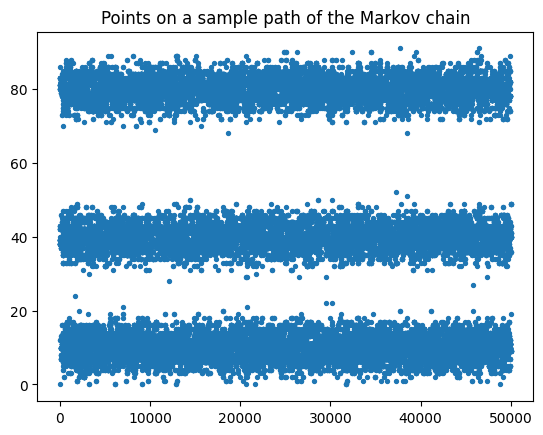

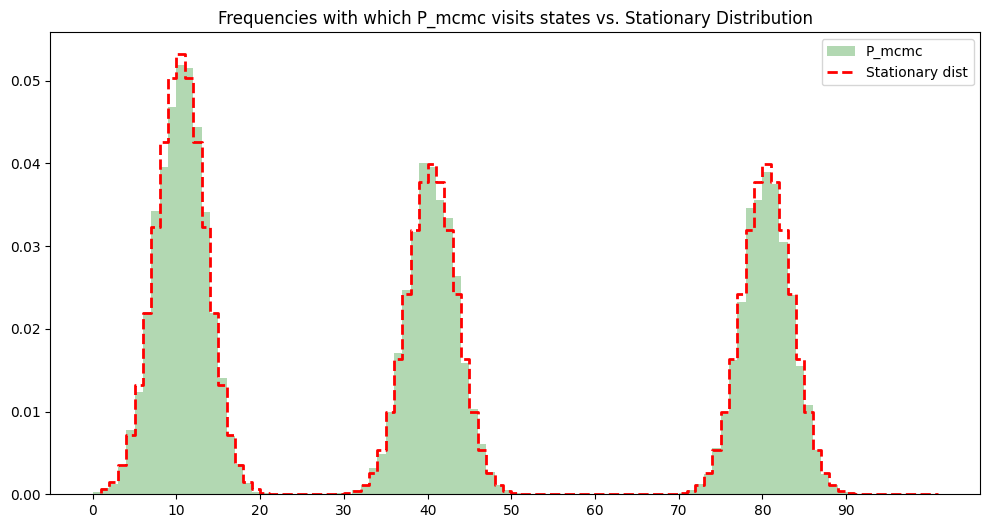

In [10]:
def transition(state: int, cum_matrix: np.ndarray, unif: float):
    """ Returns the index of the next state upon sampling from the discrete distribution P_mcmc[state] """
    return np.argmax(cum_matrix[state, :] > unif)

def generate_path_2(tr_matrix: np.ndarray, init_state: int, path_length: int):
    C = np.cumsum(tr_matrix, axis=1)
    path = np.array(init_state)
    state = init_state
    for _ in range(path_length):
        state = transition(state, C, rng.uniform(low=0., high=1.0))
        path = np.append(path, state)
    return path

def plot_density(path, label1, x, st_dist, label2):
    plt.figure(figsize=(12,6))
    #counts,bins,patches = plt.hist(path,bins=dim,facecolor='green', alpha=0.5,label=label)
    counts, bins, patches = plt.hist(path,
                                     bins=range(len(st_dist) + 1),
                                     density=True,
                                     facecolor='green', 
                                     #histtype='step',
                                     alpha=0.3,
                                     label=label1)
    plt.xticks(list(range(min(path), 1+max(path)))[::10])
    plt.step(x + 1.0, 
             st_dist,
             linewidth=2, 
             linestyle='dashed',
             color='r',
             label=label2)
    # print('bins: ', bins, len(bins))
    # print('Frequencies: ',np.round(counts,3))
    #print('Ratios: ',np.round(counts[1:]/counts[:-1],3))
    plt.legend(loc='best')
    plt.grid(False)
    plt.title("Frequencies with which P_mcmc visits states vs. Stationary Distribution" )
    return counts/np.sum(counts)

def path_centers(path: np.ndarray, centers: np.ndarray) -> np.ndarray:
    distances = np.abs(path[:, None] - centers[None, :])
    closest_index = np.argmin(distances, axis=1)
    return centers[closest_index]
    

# Generate a Markov chain sample path
path_len = 50000
rng = np.random.default_rng(10)
# uniform = rng.uniform(low=0., high=1.0, size=epochs) # random samples from Uniform[0, 1], number of samples = epochs.

initial_state = 0
# path = generate_path(P_mcmc, initial_state, uniform)
path = generate_path_2(P_mcmc, initial_state, path_len)
print(min(path), max(path))
# print(np.arange(min(path) - 0.5, max(path) + 1.0 + 0.5))
# print(list(range(len(q_dist) + 1)))
# plt.plot(path_centers(path, centers))
# plt.scatter(range(len(path)), path_centers(path, centers), s=8)
plt.scatter(range(len(path)), path, s=8)
plt.title("Points on a sample path of the Markov chain")

x = np.arange(0, len(q_dist), 1)
density = plot_density(path, 'P_mcmc', x, q_dist, 'Stationary dist')
# print('Stationary distribution: ', np.round(q_dist , 3))
# print('MCMC Density:            ', np.round(density, 3))
print(q_dist.shape, density.shape)
# print(f"Difference =              {np.round(q_dist - density, 3)}")

### Covariance
Successive samples from $P_{mcmc}$ are correlated. How much?

Text(0, 0.5, 'Covariance')

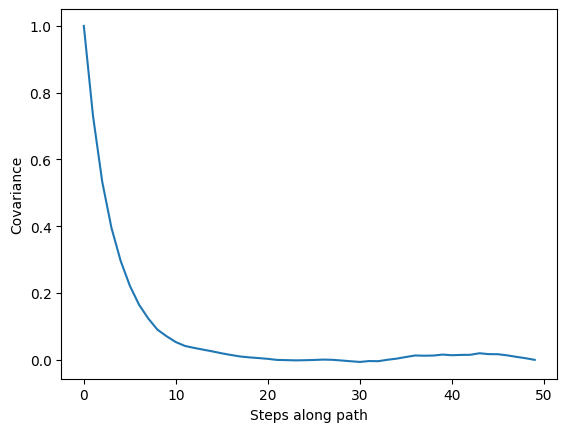

In [11]:
from scipy.ndimage import shift
def cov_function(X: np.ndarray, max_lag: int) -> np.ndarray:
    X = X - np.mean(X)
    cov_fn = np.array([])
    for lag in range(max_lag):
        cov_fn = np.append(cov_fn, np.dot(X, shift(X, lag, cval=0)))
    return cov_fn/(X.shape[0] - 1)

max_lag = 50
covs = cov_function(path, max_lag)
plt.plot(np.arange(0, covs.shape[0]), covs/covs[0])
plt.xlabel("Steps along path")
plt.ylabel("Covariance")

### Recurrence times

A Markov chain's stationary distribution at a given state is inversely proportional to the mean time between returns to that state (the mean recurrence time). This cell compares the two on the sample path created above.

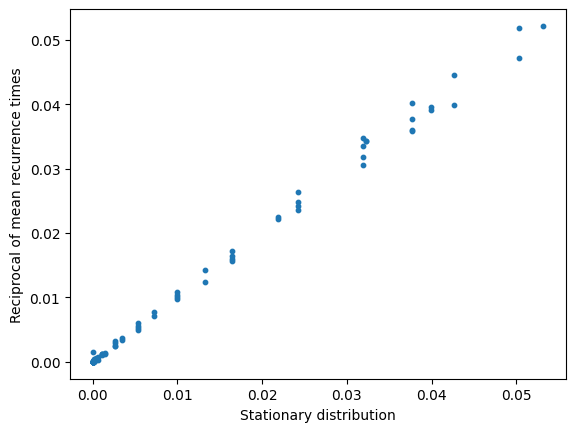

In [12]:
def mean_recurrence(path, n_states: int):
    mr = np.array([])
    states = np.arange(n_states)
    for s in states:
        v = np.where(path==s)[0]  # where returns a tuple, even if 1-dimensional
        if len(v) <= 1:
            rec = np.inf
        else:
            rec = np.mean(v[1:] - v[:-1])
            # The path may return to a given state exactly once at two consecutive times
            if isclose(rec, 1.0):
                print(v)
        mr = np.append(mr, rec)
    return mr

rec = mean_recurrence(path, n_states)
rec = 1.0/rec

# print(np.vstack((q_dist[:len(rec)], rec)).T.round(3))
plt.scatter(q_dist, rec, s=10)
plt.xlabel("Stationary distribution")
_ = plt.ylabel("Reciprocal of mean recurrence times")

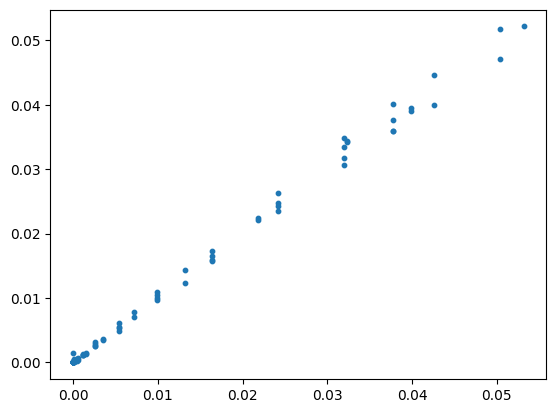

In [13]:
# Handle the case where the path returns to a state after one step
include = ~np.isclose(rec, 1.0)
plt.scatter(q_dist[include], rec[include], s=10)